# Topic extraction

Using `tomotopy`'s PAM implementation.
Comparing different number of topics and evaluating coherence.

In [2]:
%load_ext autotime

import psycopg2
import numpy 
import nltk
import wordcloud
import matplotlib.pyplot as plt
import gensim
from tqdm import tqdm
import multiprocessing
import tomotopy as tp

DATASET_NAME = '20k-lemma-nophrase'
MODEL_CLASS = 'LDAModel'
TOPIC_COUNTS = list(range(2,50))
N_REPEATS = 30
CONSTANT_PARAMS = {
    'tw': tp.TermWeight.ONE,
}

# DATASET_NAME = 'small'
# MODEL_CLASS = 'PAModel'
# TOPIC_COUNTS = list(reversed(range(2,6)))
# N_REPEATS = 2
# CONSTANT_PARAMS = {
#     'tw': tp.TermWeight.ONE,
# }


In [3]:
def log(message):
    print(message, flush=True)

time: 655 µs


In [4]:
import collections
import numpy as np

# returns x, y, sigma
def prep_metric(metas, field):
    d = collections.defaultdict(list)
    for m in metas:
        d[m.k].append(m.__getattribute__(field))
    
    x = []
    y = []
    s = []
    for k in sorted(d.keys()):
        a = np.array(d[k])
        x.append(k)
        y.append(np.average(a))
        s.append(np.std(a))

#         med = np.median(a)
#         mad = np.median(np.abs(a - med))
#         y.append(med)
#         s.append(mad)
    
    return (
        np.array(x),
        np.array(y),
        np.array(s),
    )

time: 2.02 ms


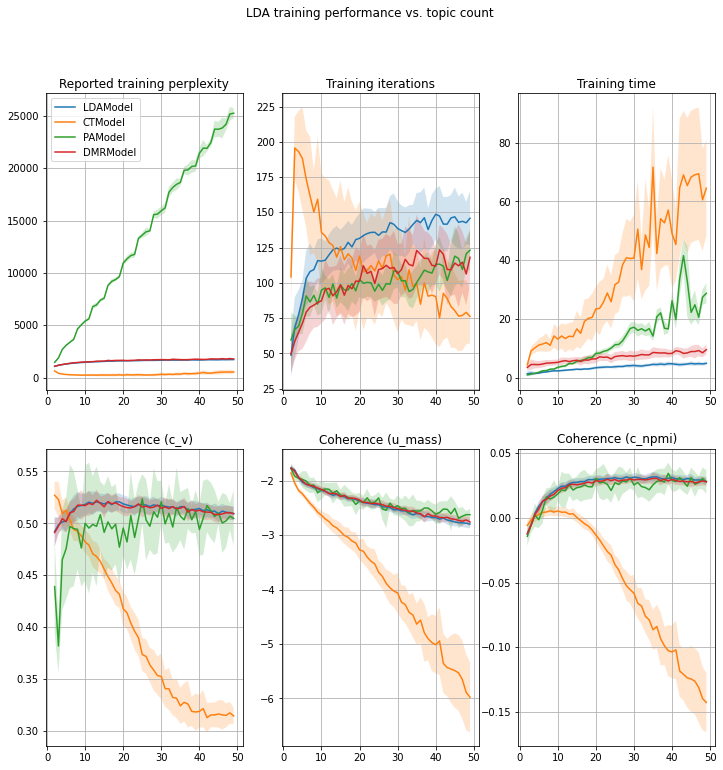

time: 1.1 s


In [10]:
import metadata as md
import sqlalchemy as sql
import sqlalchemy.sql.expression as expr

model_classes = ['LDAModel', 'CTModel', 'PAModel', 'DMRModel']
klass_metas = {} # model name -> list of metas
for klass in model_classes:
    metas = klass_metas[klass] = []
    for meta in md.session.query(md.Model).filter(
        expr.and_(
            md.Model.dataset == DATASET_NAME,
            md.Model.klass == klass,
            md.Model.k.in_(list(TOPIC_COUNTS))
        )).all():
        p = meta.params.copy()
        p.update(CONSTANT_PARAMS)
        if p != meta.params: continue
        metas.append(meta)


fig = plt.figure(figsize=(12,12))
fig.suptitle('LDA training performance vs. topic count')


plt.subplot(231)
for klass, metas in klass_metas.items():
    x,y,s = prep_metric(metas, 'perplexity')
    plt.plot(x,y, label=klass)
    plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.legend()
plt.title('Reported training perplexity')



plt.subplot(232)
for klass, metas in klass_metas.items():
    x,y,s = prep_metric(metas, 'iterations')
    plt.plot(x,y)
    plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Training iterations')


plt.subplot(233)
for klass, metas in klass_metas.items():
    x,y,s = prep_metric(metas, 'duration')
    plt.plot(x,y)
    plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Training time')


plt.subplot(234)
for klass, metas in klass_metas.items():
    x,y,s = prep_metric(metas, 'c_v')
    plt.plot(x,y)
    plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Coherence (c_v)')


plt.subplot(235)
for klass, metas in klass_metas.items():
    x,y,s = prep_metric(metas, 'c_umass')
    plt.plot(x,y)
    plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Coherence (u_mass)')


x,y,s = prep_metric(metas, 'c_npmi')

plt.subplot(236)
for klass, metas in klass_metas.items():
    x,y,s = prep_metric(metas, 'c_npmi')
    plt.plot(x,y)
    plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Coherence (c_npmi)')

plt.show()



In [13]:
m = max(metas, key=lambda m: m.c_v)
print('Best model for c_v: k=%d c_v=%.3f' % (m.k, m.c_v))

m = max(metas, key=lambda m: m.c_npmi)
print('Best model for c_npmi: k=%d' % (m.k))

Best model for c_v: k=8 c_v=0.546
Best model for c_npmi: k=45
time: 5.03 ms
